In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd

In [52]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [53]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [54]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [55]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [56]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [57]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [58]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
CY_precipitation = session.query(Measurements.date).filter(Measurements.date >= "2016-08-23").order_by(Measurements.date).all()
# # Calculate the date 1 year ago from the last data point in the database
LY_precipitation = session.query(Measurements.date).filter(Measurements.date).order_by(Measurements.date.desc()).first()
last_date = dt.date(2017,8,23) - dt.timedelta(days=365)

last_date

datetime.date(2016, 8, 23)

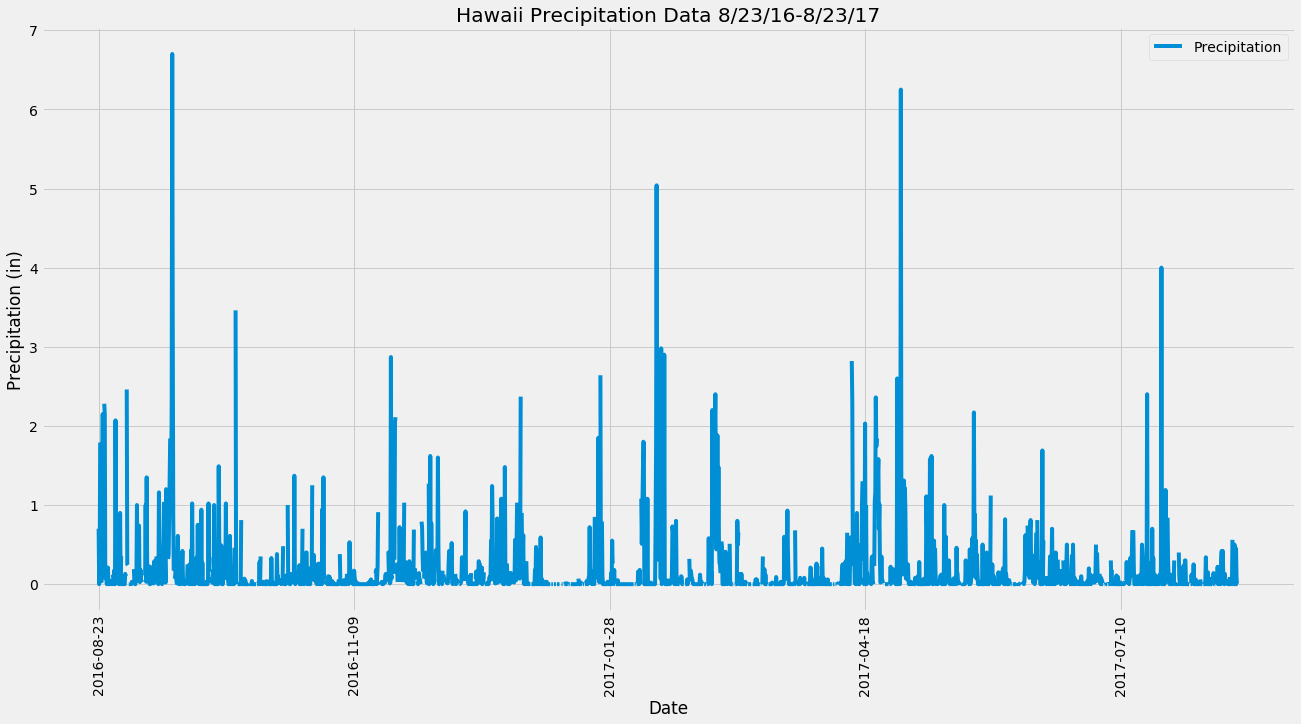

In [105]:
# # # Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurements.prcp, Measurements.date).order_by(Measurements.date.desc())
# # # Save the query results as a Pandas DataFrame and set the index to the date column, Sort the dataframe by date
date = []
precipitation = []
last_year_df = last_year.filter(Measurements.date >="2016-08-23")
for precip in last_year_df:
    date.append(precip.date)
    precipitation.append(precip.prcp)
LY_df = pd.DataFrame({
    "Date": date,
    "Precipitation": precipitation
})
LY_df.set_index("Date", inplace=True)
LY_df = LY_df.sort_index(ascending=True)

# # Use Pandas Plotting with Matplotlib to plot the data
LY_graph = LY_df.plot(figsize = (20,10), rot=90, title= "Hawaii Precipitation Data 8/23/16-8/23/17")
LY_graph.set_ylabel("Precipitation (in)")
plt.savefig("Images/PrecipitationAugtoAug.png")




In [106]:
# Use Pandas to calcualte the summary statistics for the precipitation data
LY_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [107]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurements.station, func.count(Measurements.station)).\
    group_by(Measurements.station).all()

print("There are " + str(len(station_count)) + " stations in this dataset.")

There are 9 stations in this dataset.


In [123]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurements.station, func.count(Measurements.station)).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [128]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = session.query(Measurements.station).group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).first()

most_active_info = session.query(Measurements.station, func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
    filter(Measurements.station == most_active[0]).all()

print("The lowest temperature at station " + most_active_info[0][0] + " is " + str(most_active_info[0][1]) + " degrees.")
print("The highest temperature at station " + most_active_info[0][0] + " is " + str(most_active_info[0][2]) + " degrees.")
print("The average temperature at station " + most_active_info[0][0] + " is " + str(round(most_active_info[0][3], 2)) + " degrees.")

The lowest temperature at station USC00519281 is 54.0 degrees.
The highest temperature at station USC00519281 is 85.0 degrees.
The average temperature at station USC00519281 is 71.66 degrees.


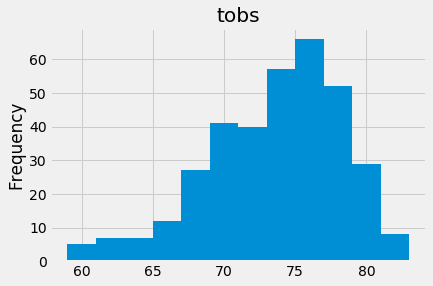

In [132]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_query = session.query(Measurements.station).group_by(Measurements.station).order_by(func.count(Measurements.id).desc()).first()
tobs = session.query(Measurements.station, Measurements.tobs).filter(Measurements.station == tobs_query[0]).filter(Measurements.date > last_date).all()

station_df = pd.DataFrame(tobs, columns = ['station', 'tobs'])
station_df.hist(column='tobs', bins=12)
plt.ylabel('Frequency')
plt.show()